For SubRegion data 
- Assign each weather grid to each Region
- Use weather grid after filtering w Veg data

In [2]:
# Force garbage collection
import gc
gc.collect()

474

In [3]:
# del all variables
import sys
for name in dir():
    if not name.startswith('_'):
        del globals()[name]

In [4]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import pyproj
from tqdm import tqdm
import numpy as np
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime

In [5]:
# check python version and all packages version
def check_python_version():
    import sys
    print("Python version")
    print (sys.version)
    print("Pandas version")
    print(pd.__version__)
    print("Geopandas version")
    print(gpd.__version__)
    print("Xarray version")
    print(xr.__version__)
    print("Pyproj version")
    print(pyproj.__version__)

check_python_version()

Python version
3.11.9 | packaged by Anaconda, Inc. | (main, Apr 19 2024, 16:40:41) [MSC v.1916 64 bit (AMD64)]
Pandas version
2.2.2
Geopandas version
0.14.2
Xarray version
2023.6.0
Pyproj version
3.6.1


In [6]:
entity = 'SubRegion'
data_dir = f'../../Extended_Data/{entity}/'

In [7]:
files = os.listdir(data_dir)
files

['ca_subregions_5.cpg',
 'ca_subregions_5.dbf',
 'ca_subregions_5.prj',
 'ca_subregions_5.shp',
 'ca_subregions_5.shx',
 'subregion_summary.csv']

In [8]:
file = 'subregion_summary.csv'
df = pd.read_csv(os.path.join(data_dir, file))

In [9]:
df

,SubRegion,Ecoregions
0,Central Coast,Central California Foothills and Coastal Mount...
1,North Coast,Coast Range; Klamath Mountains/California High...
2,North Interior,Cascades; Eastern Cascades Slopes and Foothill...
3,Sierra Nevada,Central Basin and Range; Sierra Nevada
4,South Coast,Southern California Mountains; Southern Califo...


In [10]:
gdf_subregion = gpd.read_file(f'{data_dir}ca_subregions_5.shp')

In [11]:
gdf_subregion.columns, gdf_subregion.shape

(Index(['SubRegion', 'US_L3CODE', 'US_L3NAME', 'NA_L3CODE', 'NA_L3NAME',
        'NA_L2CODE', 'NA_L2NAME', 'NA_L1CODE', 'NA_L1NAME', 'STATE_NAME',
        'EPA_REGION', 'L3_KEY', 'L2_KEY', 'L1_KEY', 'geometry'],
       dtype='object'),
 (5, 15))

In [12]:
col_to_keep = ['SubRegion', 'geometry']
gdf_subregion = gdf_subregion[col_to_keep]

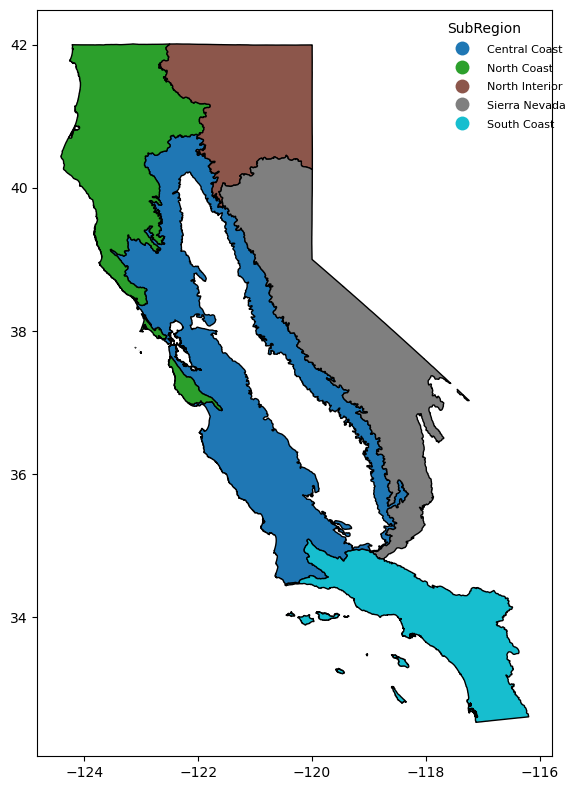

In [13]:
fig, ax = plt.subplots(figsize=(10, 8))
gdf_subregion.plot(column='SubRegion', legend=True, cmap='tab10', edgecolor='black', ax=ax)

# Get the legend and adjust its properties
leg = ax.get_legend()
if leg is not None:
    leg.set_bbox_to_anchor((1.05, 1))  # Move legend outside plot
    leg.set_title("SubRegion", prop={'size': 10})
    for text in leg.get_texts():
        text.set_fontsize(8)  # Set font size for legend labels
    leg._legend_box.align = "left"
    leg.set_frame_on(False)  # Optional: remove legend frame

plt.tight_layout()
plt.show()

In [14]:
print(f"Current CRS: {gdf_subregion.crs}")

Current CRS: EPSG:4326


In [73]:
reference_weather_data = pd.read_parquet('../../Clean_Data/Weather_Data/Combined_Weather_Data_w_Veg_Filter/wind_speed.parquet')
reference_weather_data = reference_weather_data[reference_weather_data['day']=='1998-01-01']
reference_weather_data = reference_weather_data[['lon', 'lat']].drop_duplicates().reset_index(drop=True)
reference_weather_data.shape

(14383, 2)

In [74]:
from shapely.geometry import Point

# 1. Convert points DataFrame to GeoDataFrame
weather_points = gpd.GeoDataFrame(
    reference_weather_data,
    geometry=gpd.points_from_xy(reference_weather_data['lon'], reference_weather_data['lat']),
    crs='EPSG:4326'  # Use the same CRS as your subregion polygons
)

# 2. Read your subregion polygons shapefile (or use your existing GeoDataFrame)
# gdf_subregions = gpd.read_file('path_to_subregion_shapefile.shp')

# 3. Spatial join: assign each point to a subregion (if any)
gdf_points_with_region = gpd.sjoin(
    weather_points, gdf_subregion, how='left', predicate='within'
)

# 4. The subregion info (e.g., subregion name/label) will be in the resulting DataFrame
# For example, if the subregion label column is 'subregion_name':
reference_weather_data['SubRegion'] = gdf_points_with_region['SubRegion']

# Now, df_points has a new column 'subregion' with the matched subregion label (or NaN if not in any subregion)

In [23]:
reference_weather_data.head()

,lon,lat,SubRegion
0,-124.391667,40.441667,North Coast
1,-124.391667,40.400000,NaN
2,-124.350000,40.525000,North Coast
3,-124.350000,40.483333,North Coast
4,-124.350000,40.441667,North Coast


In [75]:
# missing rate in all columns
reference_weather_data.isnull().mean() * 100

lon          0.000000
lat          0.000000
SubRegion    9.281791
dtype: float64

In [76]:
# fill na with 'Unknown'
reference_weather_data['SubRegion'] = reference_weather_data['SubRegion'].fillna('Unknown')

subregion_mapping = {
 'Unknown': 0,
 'North Coast': 1,
 'Central Coast': 2,
 'North Interior': 3,
 'Sierra Nevada': 4,
 'South Coast': 5}
reference_weather_data['SubRegion_num'] = reference_weather_data['SubRegion'].map(subregion_mapping)

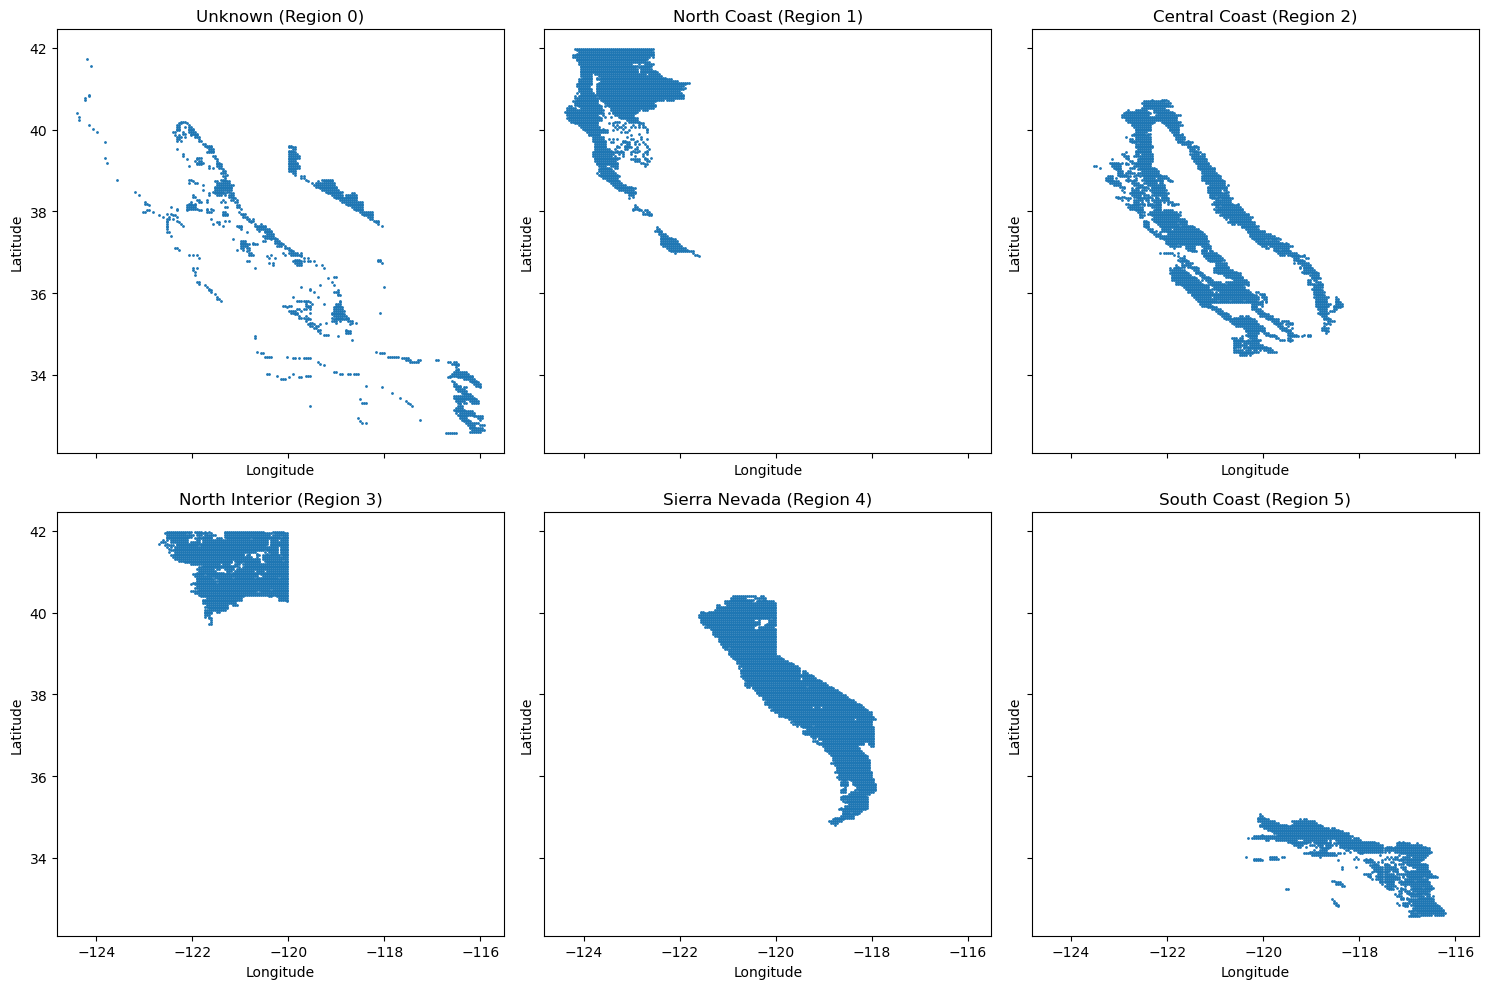

In [77]:
import matplotlib.pyplot as plt

region_nums = sorted(reference_weather_data['SubRegion_num'].dropna().unique())
fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)

for idx, region_num in enumerate(region_nums):
    ax = axes.flat[idx]
    subset = reference_weather_data[reference_weather_data['SubRegion_num'] == region_num]
    ax.scatter(subset['lon'], subset['lat'], s=1, c='tab:blue')
    # get assigned subregion name from subregion_mapping
    subregion_name = [name for name, num in subregion_mapping.items() if num == region_num][0]
    ax.set_title(f'{subregion_name} (Region {region_num})')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

# Hide the 6th subplot if only 5 regions
if len(region_nums) < 6:
    axes.flat[-1].axis('off')

plt.tight_layout()
plt.show()

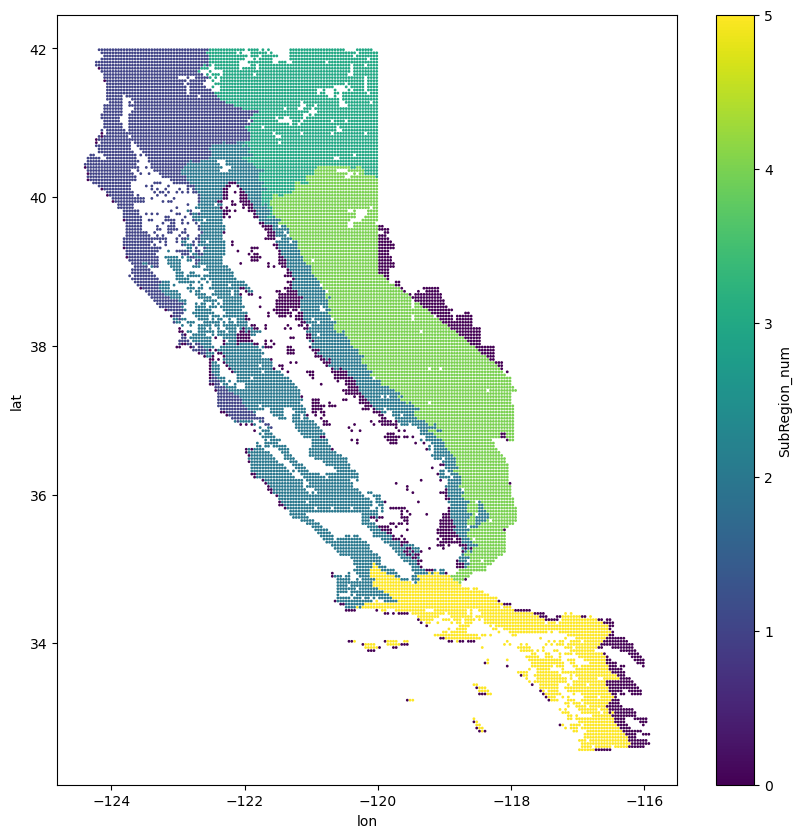

In [78]:
reference_weather_data.plot(kind='scatter', x='lon', y='lat', c='SubRegion_num', cmap='viridis', s=1, figsize=(10, 10))
plt.show()

In [79]:
# check missing rate for all columns
reference_weather_data.isnull().mean() * 100

lon              0.0
lat              0.0
SubRegion        0.0
SubRegion_num    0.0
dtype: float64

In [80]:
reference_weather_data.shape # same as before

(14383, 4)

In [81]:
# from the map, the missing looks reasonable, so we can drop it
# remove SubRegion = 'Unknown'
reference_weather_data = reference_weather_data[reference_weather_data['SubRegion'] != 'Unknown']

In [82]:
reference_weather_data.shape

(13048, 4)

In [84]:
# drop SubRegion_num column
reference_weather_data = reference_weather_data.drop(columns=['SubRegion_num'])

## Save Data

In [85]:
reference_weather_data.head()

,lon,lat,SubRegion
0,-124.391667,40.441667,North Coast
2,-124.350000,40.525000,North Coast
3,-124.350000,40.483333,North Coast
4,-124.350000,40.441667,North Coast
5,-124.350000,40.400000,North Coast


In [87]:
path_to_save = f'../../Clean_Data/Extended_Data_w_Veg_Filter/{entity}'
file_name = 'lon_lat_pair_weather_match_subregion.parquet'
# Ensure the output directory exists
if not os.path.exists(path_to_save):
    os.makedirs(path_to_save)

output_file = f'{path_to_save}/{file_name}'
reference_weather_data.to_parquet(output_file)

In [88]:
import gc
gc.collect()

49781